In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten,LeakyReLU,BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Flatten
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,DepthwiseConv2D
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D, Concatenate
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K


2024-04-07 19:29:16.349416: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 19:29:16.349486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 19:29:16.350944: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set some parameters
im_width = 256
im_height = 256
ids1 = next(os.walk("/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images"))[2]
X = np.zeros((len(ids1), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids1), im_height, im_width, 1), dtype=np.float32)
# tqdm is used to display the progress bar
# X.shape

In [3]:
len(ids1)

2841

In [4]:
for n, id_ in tqdm(enumerate(ids1)):
    # Load images
    img = load_img("/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/" + id_, color_mode = 'grayscale')
    x_img = img_to_array(img)
    x_img = resize(x_img, (256, 256, 1), mode='constant', preserve_range=True)
    # Load masks
    mask = img_to_array(load_img("/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/" + id_, color_mode = 'grayscale'))
    mask = resize(mask, (256, 256, 1), mode='constant', preserve_range=True)
    # Save images
    X[n] = x_img / 255.0
    y[n] = mask / 255.0

2841it [03:08, 15.05it/s]


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3,shuffle=True)

In [6]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 5, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 5, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [7]:


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function


In [8]:
def unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    #print(s4.shape , p4.shape)
    s5, p5 = encoder_block(p4, 1024)
    #print(s5.shape , p5.shape)
    
    b1 = conv_block(p5, 2048)


    d1 = decoder_block(b1, s5, 1024)
    d2 = decoder_block(d1, s4, 512)
    d3 = decoder_block(d2, s3, 256)
    d4 = decoder_block(d3, s2, 128)
    d5 = decoder_block(d4, s1, 64)
    print("----------------------------------")
    print("\n")
    print(b1.shape , s5.shape)
    print(d1.shape , s4.shape)
    print(d2.shape , s3.shape)
    print(d3.shape , s2.shape)
    print(d4.shape , s1.shape)
    print("\n")
    print(d5.shape,"\n")
    print("----------------------------------")

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d5)
    print(outputs.shape)
    print("----------------------------------")
    model = Model(inputs, outputs, name="U-NET")
    return model

model = unet((256,256,1))
model.summary()

----------------------------------


(None, 8, 8, 2048) (None, 16, 16, 1024)
(None, 16, 16, 1024) (None, 32, 32, 512)
(None, 32, 32, 512) (None, 64, 64, 256)
(None, 64, 64, 256) (None, 128, 128, 128)
(None, 128, 128, 128) (None, 256, 256, 64)


(None, 256, 256, 64) 

----------------------------------
(None, 256, 256, 1)
----------------------------------


Model: "U-NET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,664 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │    102,464 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │    204,928 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    409,728 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    819,456 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 325,605,697 (1.21 GB)

 Trainable params: 325,581,633 (1.21 GB)

 Non-trainable params: 24,064 (94.00 KB)

In [9]:
y_train.shape

(2272, 256, 256, 1)

In [10]:
model.compile(optimizer = 'adam' ,loss = [jacard_coef_loss], metrics = [jacard_coef])

history = model.fit(X_train, y_train, batch_size=16, epochs=50)

Epoch 1/50


W0000 00:00:1712518499.135258     163 hlo_rematerialization.cc:2946] Can't reduce memory use below 8.62GiB (9251138752 bytes) by rematerialization; only reduced to 9.73GiB (10452575900 bytes), down from 12.36GiB (13269926204 bytes) originally
I0000 00:00:1712518506.290846     163 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


142/142 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - jacard_coef: 0.4095 - loss: -0.4095
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - jacard_coef: 0.4671 - loss: -0.4671
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - jacard_coef: 0.4779 - loss: -0.4779
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - jacard_coef: 0.4891 - loss: -0.4891
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - jacard_coef: 0.4928 - loss: -0.4928
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - jacard_coef: 0.5249 - loss: -0.5249
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - jacard_coef: 0.4863 - loss: -0.4863
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - jacard_coef: 0.5345 - loss: -0.5345
Epoch 9/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - jacard_coef: 0.5655 - loss: -0.5655
Epoch 10/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - jacard_coef: 0.5421 - loss: -0.5421
Epoch 11/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - jacard_coef: 0.5312 - loss: -0.5312
Epoch 12

In [11]:
# Evaluate the model on test data
loss, IOU = model.evaluate(X_test, y_test)
print("Test IOU:", IOU)

# Predict masks on test data
y_pred = model.predict(X_test)

# Convert predicted masks to binary values
y_pred_binary = (y_pred > 0.5).astype(np.uint8)
y_test = (y_test > 0.5).astype(np.uint8)



2024-04-07 22:01:10.775033: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,256,256]{3,2,1,0}, f32[64,128,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-07 22:01:11.258264: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.483422376s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,256,256]{3,2,1,0}, f32[64,128,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0

17/18 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - jacard_coef: 0.6389 - loss: -0.6389

2024-04-07 22:02:35.062504: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[25,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,128,256,256]{3,2,1,0}, f32[64,128,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-07 22:02:35.222227: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.159849328s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[25,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,128,256,256]{3,2,1,0}, f32[64,128,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0

18/18 ━━━━━━━━━━━━━━━━━━━━ 159s 5s/step - jacard_coef: 0.6384 - loss: -0.6384
Test IOU: 0.6342052817344666
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step


In [12]:
X_test.shape

(569, 256, 256, 1)

In [23]:
import random
rand_num = random.randint(0,569)
print(rand_num)

251


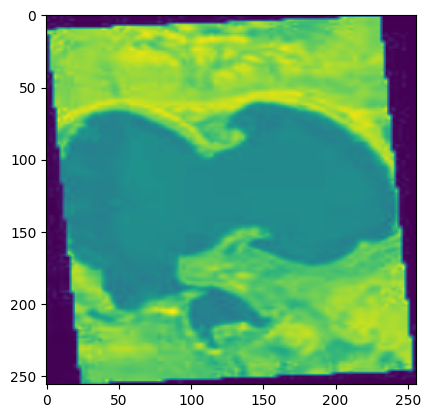

In [24]:
img_demo = X_test[rand_num]
plt.imshow(img_demo)

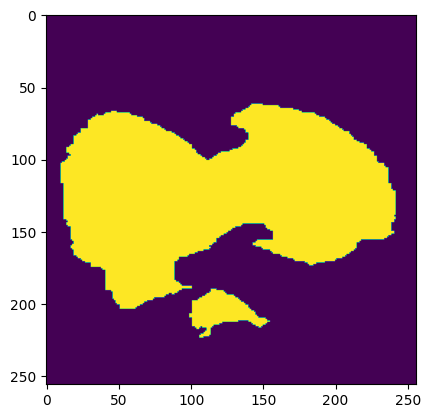

In [25]:
seg_demo = y_test[rand_num]
plt.imshow(seg_demo)

In [21]:
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    dice = (2.0 * intersection) / (union + intersection)
    return dice
dice_scores = []
for i in range(len(X_test)):
    dice = dice_coefficient(y_test[i], y_pred_binary[i])
    dice_scores.append(dice)
average_dice = np.mean(dice_scores)
print("Average Dice Score:", average_dice)


Average Dice Score: 0.5201349610899145


In [22]:
model.save_weights('/kaggle/working/Water_Bodies.weights.h5')
model.load_weights('/kaggle/working/Water_Bodies.weights.h5')
